# Про что этот ноутбук

В этом ноутбуке можно найти __три подхода__ к __сравнению__ двух __распределений данных__. Эти примеры детально разобраны - в них __шаг за шагом__ объясняется, как получить численную оценку, которая характеризует сходство или различие данных.
- Population stability Index (PSI)
- Критерий Колмогорова-Смирнова
- Adversarial Validation Score

_____
- *Этот ноутбук так же использовался для написания статьи https://habr.com/ru/companies/ru_mts/articles/817483/*
- *В telegram есть еще много чего интересного https://t.me/+HdRZec7VJEVlNmVi*
_____

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, kstest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [3]:
plt.rcParams.update({'font.size': 15})

In [4]:
import scipy
print(scipy.__version__)

import numpy
print(numpy.__version__)

import matplotlib
print(matplotlib.__version__)

import sklearn
print(sklearn.__version__)

1.11.4
1.25.2
3.8.2
1.3.2


_____
# Population stability Index (PSI)
Пример расчета PSI на простом примере

In [5]:
# генерируем два распределения: arr_a и arr_b
arr_a = (beta.rvs(1, 2, 0, size=1000))      # исходное распределение А
arr_b = (beta.rvs(1.9, 2.6, 0, size=1000))  # исходное распределение Б

# задаем число бинов и общие границы бинов
n_bins = 7
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

### Оцениваем похожесть распределений

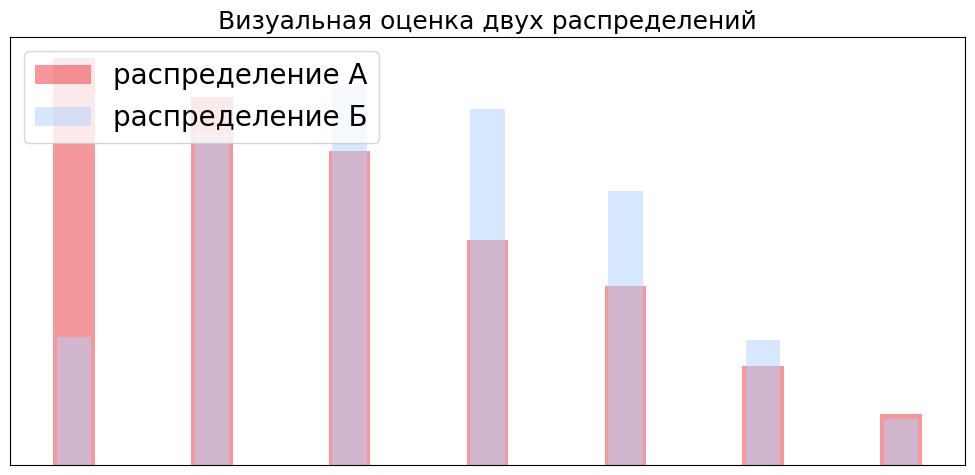

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

shift = 0.035

cnt_a = plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.5)
cnt_b = plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.5)

plt.yticks([])
plt.xticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()
plt.legend(fontsize=20, loc='upper left')
plt.title('Визуальная оценка двух распределений')

plt.tight_layout()
plt.show()

Визуально оценили и поняли, что данные отличаются друг от друга

### Первый шаг в расчете PSI
- считаем попарно diff между бинами

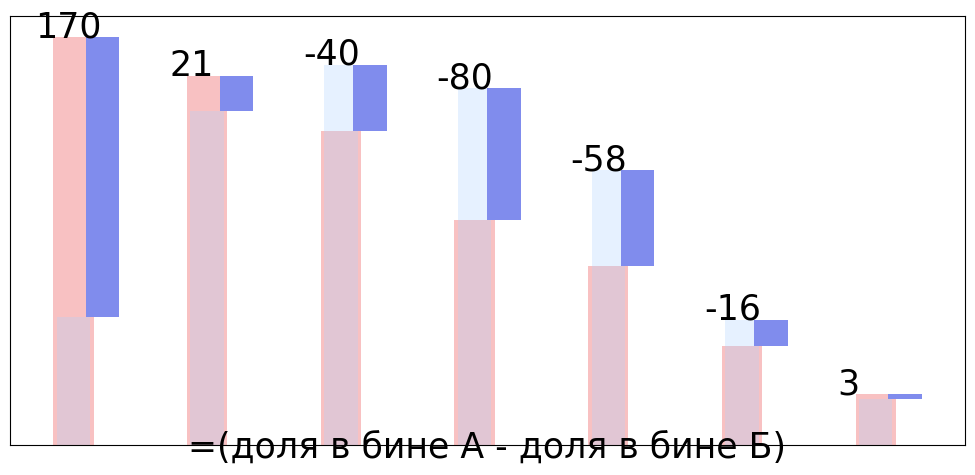

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
diff = arr_a - arr_b

plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.3)
plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.3)

plt.title('=(доля в бине А - доля в бине Б)', fontsize=25, y=-0.05, x=0.50)
plt.bar(
    bins[: -1]+0.1
    , abs(cnt_a[0] - cnt_b[0])
    , bottom=np.min([cnt_a[0], cnt_b[0]], axis=0)
    , color='#808CED'
    , width=[shift] * (len(bins)-1)
    , alpha=1
    , label='bin_1 - bin_2'
)

for idx, diff in enumerate(cnt_a[0] - cnt_b[0]):
    plt.text(
        x=bins[idx]+0.03
        , y=max((cnt_b[0])[idx], (cnt_a[0])[idx]) + 0.002
        , s=f"{diff:0.0f}"
        , fontsize=25
    )

plt.yticks([])
plt.xticks([])
plt.grid(False)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.tight_layout()
plt.show()

Посчитали разницу между значениями в бинах у распределения А и распределения Б

Видим что она совершенно разная от бина к бину

### Второй шаг в расчете PSI
- Попарно делим значение бина А на значение бина Б 

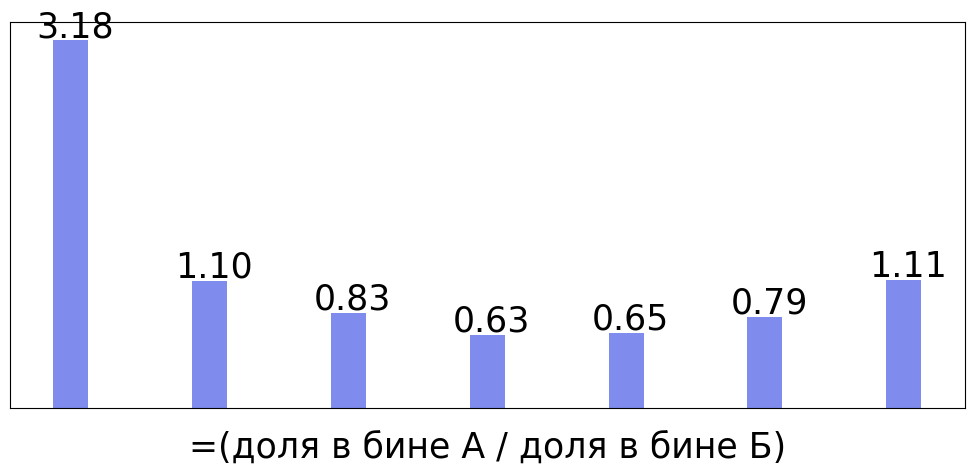

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('=(доля в бине А / доля в бине Б)', fontsize=25, y=-0.15, x=0.50)
plt.bar(
    bins[: -1]+0.0346
    , (cnt_a[0] / cnt_b[0])
    , color='#808CED'
    , width=[shift] * (len(bins)-1)
    , alpha=1
    , label='bin_1 - bin_2'
)

for idx, diff in enumerate((cnt_a[0] / cnt_b[0])):
    plt.text(
        x=bins[idx]
        , y=(cnt_a[0] / cnt_b[0])[idx] + 0.03
        , s=f"{diff:0.2f}"
        , fontsize=25
    )

plt.xticks([])
plt.yticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.grid(False)
plt.tight_layout()
plt.show()

Делим количество наблюдений бина А на количество наблюдений в бине Б.

Получаем оценку, во сколько раз одно значение больше или меньше другого значения распределения А и Б

### Третий шаг в расчете PSI
- По формуле высчитываем значение PSI


$PSI = \sum{}\Big(\big(Actual \% - Expected \%\big) \times ln\big(\dfrac{Actual \%}{Expected \%}\big)\Big)$

In [9]:
# отнормируем число значений в бине к 1
cnt_a = [cnt_a[0] / sum(cnt_a[0])]
cnt_b = [cnt_b[0] / sum(cnt_b[0])]

In [10]:
# итоговый PSI
np.sum([
    diff * np.log(div) for (div, diff) in (
        zip(
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (cnt_a[0] / cnt_b[0])], 
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (cnt_a[0] - cnt_b[0])], 
        )
    )
])

0.27194174583872693

### или альтернативный подход

In [11]:
bucket_edges = np.linspace(
    min(np.min(arr_a), np.min(arr_b))
    , max(np.max(arr_a), np.max(arr_b))
    , n_bins+1
)

In [12]:
expected_hist, _ = np.histogram(arr_a, bins=bucket_edges)
actual_hist, _ = np.histogram(arr_b, bins=bucket_edges)

expected_hist = expected_hist / sum(expected_hist)
actual_hist = actual_hist / sum(actual_hist)

In [13]:
# итоговый PSI
np.sum([
    diff * np.log(div) for (div, diff) in (
        zip(
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (expected_hist / actual_hist)], 
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (expected_hist - actual_hist)], 
        )
    )
])

0.27194174583872693

_____
# Критерий Колмогорова-Смирнова

In [14]:
# задаем начальные распределения
arr_a = (beta.rvs(1, 3, 0, size=10000))  # исходное распределение А
arr_b = (beta.rvs(2, 5, 0, size=10000))  # исходное распределение Б

n_bins = 7
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

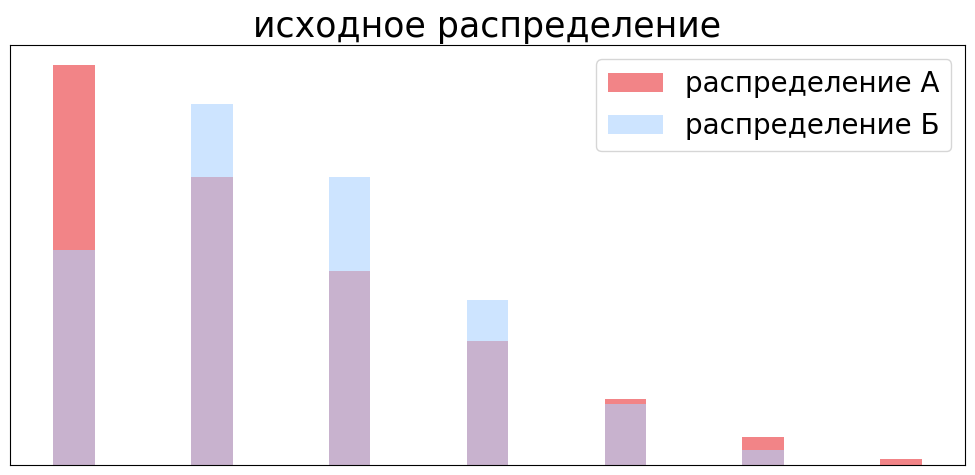

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

plt.hist(
    arr_a
    , bins=bins
    , color='#EA3338'
    , rwidth=0.3
    , label='распределение А'
    , alpha=0.6
)

plt.hist(
    arr_b
    , bins=bins
    , color='#ADD2FF'
    , rwidth=0.3
    , label='распределение Б'
    , alpha=0.6
)

plt.title('исходное распределение', y=1., fontsize=25)

plt.grid(False)
plt.legend(fontsize=20)

plt.tight_layout()
plt.savefig('../pictures/ks_1.png', dpi=100, format='png')

### Первый шаг в расчете критерия Колмогорова-Смирнова

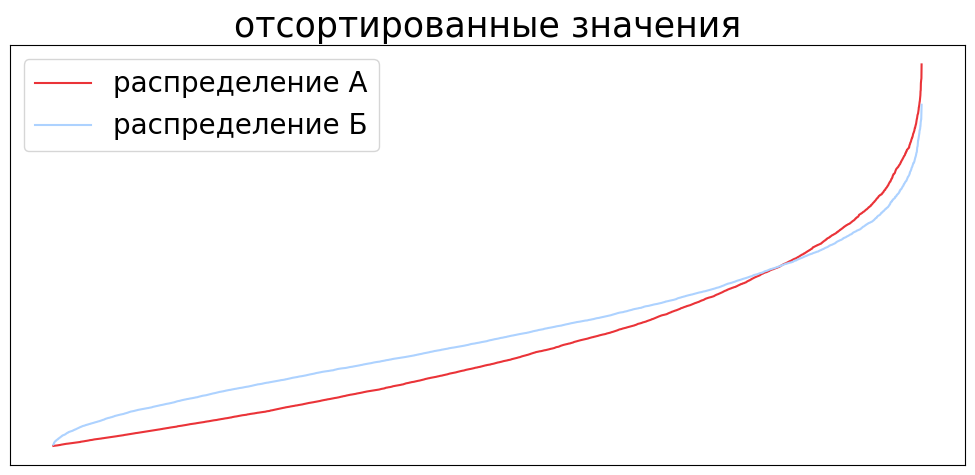

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('отсортированные значения', y=1., fontsize=25)

a_ = np.sort(arr_a)
b_ = np.sort(arr_b)

plt.plot(a_, label='распределение А', color='#EA3338')
plt.plot(b_, label='распределение Б', color='#ADD2FF')

plt.legend(fontsize=20)
plt.grid(False)
plt.yticks([])
plt.xticks([])

plt.tight_layout()
plt.savefig('../pictures/ks_2.png', dpi=100, format='png')

Отсортировали каждое распределение по возрастанию и наложили друг на друга

Визуально сравнили

### Второй шаг в расчете критерия Колмогорова-Смирнова
Приводим распределение А к распределению Б или наоборот - распределение Б к распределению А. (зависит от проверяемой гипотезы, [вот тут подробнее](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)) 

Делается это через бининг по значениям одного из распределений.

In [17]:
a_to_b = np.searchsorted(sorted(arr_a), sorted(arr_b), side='right') / len(arr_a)
b_to_b = np.searchsorted(sorted(arr_b), sorted(arr_b), side='right') / len(arr_b)
idx_max_1 = np.argmax(abs(a_to_b - b_to_b))
idx_min_1 = np.argmax(-(a_to_b - b_to_b))

b_to_a = np.searchsorted(sorted(arr_b), sorted(arr_a), side='right') / len(arr_b)
a_to_a = np.searchsorted(sorted(arr_a), sorted(arr_a), side='right') / len(arr_a)
idx_max_2 = np.argmax(abs(b_to_a - a_to_a))
idx_min_2 = np.argmax(-(a_to_a-b_to_a))

Здесь используется функция np.searchsorted, которая находит индексы, куда элементы из одного массива (например, sorted(arr_b)) должны быть вставлены в другой отсортированный массив (например, sorted(arr_a)) для сохранения порядка.
- a_to_b показывает, где элементы из arr_b должны быть вставлены в arr_a.
- b_to_b показывает, где элементы из arr_b должны быть вставлены в сам arr_b.


Деление на длину массива нормализует значения, приводя их к диапазону от 0 до 1. Это позволяет сравнивать CDF (функции распределения) двух массивов.

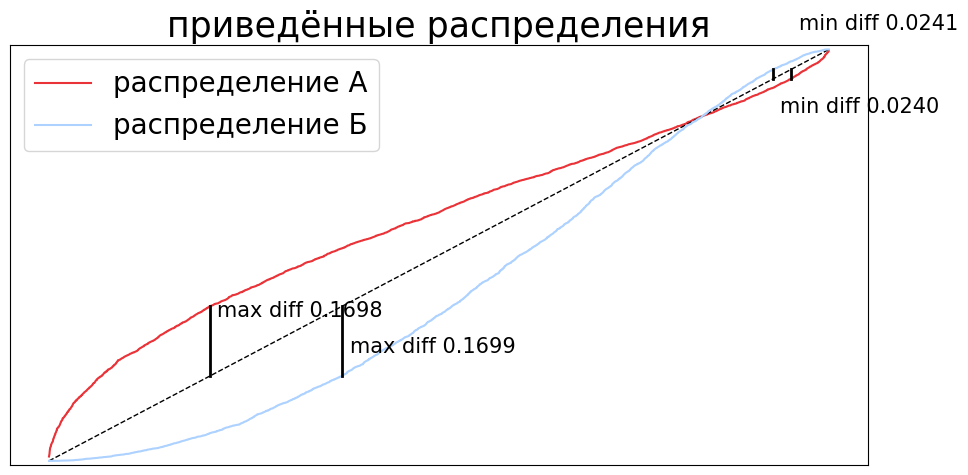

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('приведённые распределения', y=1., fontsize=25)

plt.plot(a_to_b, label='распределение А', color='#EA3338')

plt.plot([0, len(a_to_b)], [0, 1], color='black', linestyle='--', linewidth=1)

plt.plot(b_to_a, label='распределение Б', color='#ADD2FF')


# гипотеза - greater
plt.plot([idx_max_2, idx_max_2], [b_to_b[idx_max_2], b_to_a[idx_max_2]], color='black', linewidth=2)
plt.plot([idx_max_1, idx_max_1], [b_to_b[idx_max_1], a_to_b[idx_max_1]], color='black', linewidth=2)

plt.text(idx_max_1+100, np.mean([b_to_b[idx_max_1], a_to_b[idx_max_1]])*1.2, s=f'max diff {max(abs(a_to_b - b_to_b)):0.4f}')
plt.text(idx_max_2+100, np.mean([a_to_a[idx_max_2], b_to_a[idx_max_2]])*0.9, s=f'max diff {max(abs(b_to_a - a_to_a)):0.4f}')


# гипотеза - less
plt.plot([idx_min_1, idx_min_1], [a_to_b[idx_min_1], b_to_b[idx_min_1]], color='black', linewidth=2)
plt.plot([idx_min_2, idx_min_2], [a_to_a[idx_min_2], b_to_a[idx_min_2]], color='black', linewidth=2)

plt.text(idx_min_1+100, np.mean([a_to_a[idx_min_1], b_to_b[idx_min_1]])*1.1, s=f'min diff {max(-(a_to_b - a_to_a)):0.4f}')
plt.text(idx_min_2+100, np.mean([a_to_a[idx_min_2], b_to_a[idx_min_2]])*0.9, s=f'min diff {max(-(b_to_b - b_to_a)):0.4f}')

plt.legend(fontsize=20, loc='upper left')

plt.ylim(-0.01, 1.01)
plt.grid(False)
plt.yticks([])
plt.xticks([])

plt.tight_layout()
plt.savefig('../pictures/ks_3.png', dpi=100, format='png')

In [19]:
# то, что мы посчитали сами
print(round(max(abs(b_to_a - a_to_a)), 4), round(max(abs(a_to_b - b_to_b)), 4))

0.1699 0.1698


In [20]:
# то, что мы посчитали сами (less)
print(round(min(max(-(a_to_b - b_to_b)), max(-(b_to_a - a_to_a))), 4))

0.0241


In [21]:
# сравнение с scipy
print(round(kstest(arr_a, arr_b, alternative='less').statistic, 4))
print(round(kstest(arr_a, arr_b, alternative='greater').statistic, 4))

0.0241
0.1699


Видим, что наша оценка совпадает с оценкой из scipy (с небольшой погрешностью)

____
# Adversarial Validation Score

In [69]:
arr_a = (beta.rvs(10, 2, 0, size=1000))      # исходное распределение А
arr_b = (beta.rvs(10.2, 2.6, 0, size=1000))  # исходное распределение Б

n_bins = 10
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

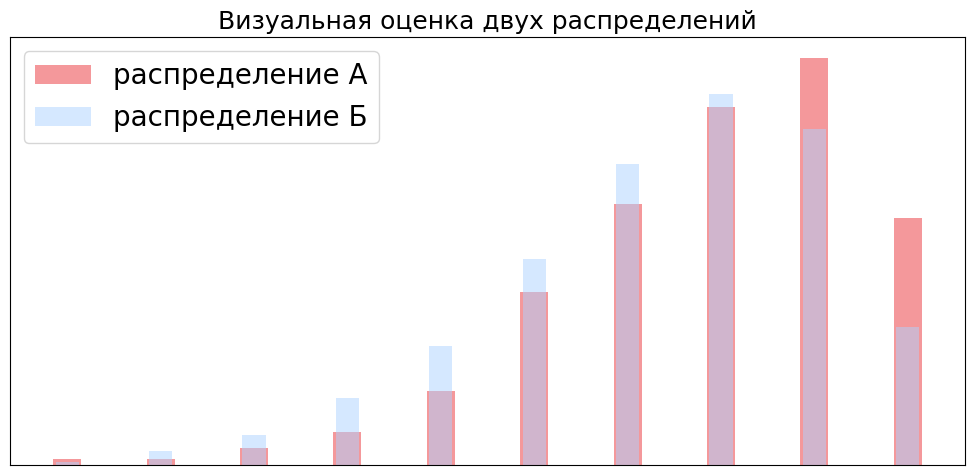

In [70]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

shift = 0.035

cnt_a = plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.5)
cnt_b = plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.5)

plt.yticks([])
plt.xticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()
plt.legend(fontsize=20, loc='upper left')
plt.title('Визуальная оценка двух распределений')

plt.tight_layout()
plt.show()

### Первый шаг в расчете adversarial validation score
Делаем бинарную разметку
- распределение А - это target 1
- распределение Б - это target 0

In [71]:
target = np.hstack([np.ones(arr_a.shape[0]), np.zeros(arr_b.shape[0])])
X = np.hstack([arr_a, arr_b]).reshape(-1, 1)

### Второй шаг в расчете adversarial validation score
Считаем на кросс-валидации некоторую метрику качества бинарной классификации, например ROC AUC

In [72]:
np.mean(
    cross_val_score(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=1)
        , X=X
        , y=target
        , cv=5
        , scoring='roc_auc'
    )
)

0.5588025

### Смотрим на более непохожее распределение

In [78]:
arr_a = (beta.rvs(2, 4, 0, size=1000))  # исходное распределение А
arr_b = (beta.rvs(9, 4, 0.1, size=1000))  # исходное распределение Б

n_bins = 10
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

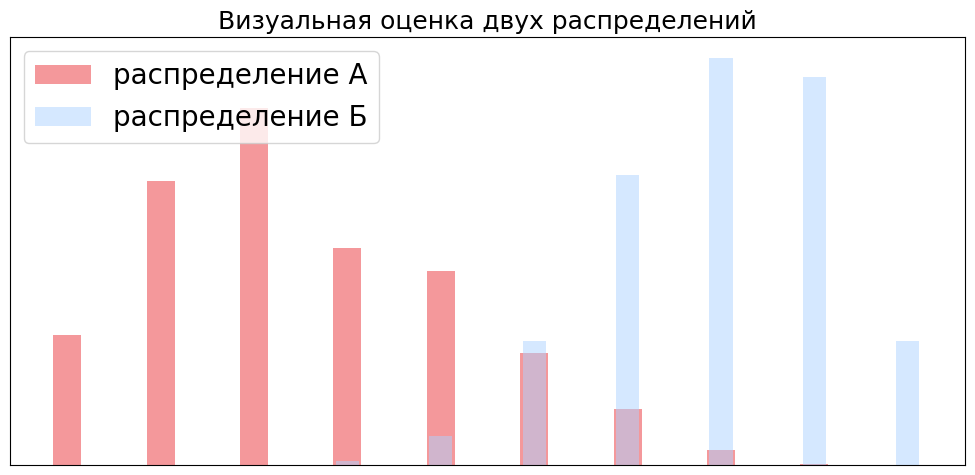

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

shift = 0.035

cnt_a = plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.5)
cnt_b = plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.5)

plt.yticks([])
plt.xticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()
plt.legend(fontsize=20, loc='upper left')
plt.title('Визуальная оценка двух распределений')

plt.tight_layout()
plt.show()

In [83]:
target = np.hstack([np.ones(arr_a.shape[0]), np.zeros(arr_b.shape[0])])
X = np.hstack([arr_a, arr_b]).reshape(-1, 1)

In [84]:
np.mean(
    cross_val_score(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=1)
        , X=X
        , y=target
        , cv=5
        , scoring='roc_auc'
    )
)

0.9758700000000001

_____
В первом случае метрика была ниже, чем во втором. Обычно выделяют границы
- ```<= 0.55``` - данные не различаются
- ```>= 0.85``` - данные различаются значительно

In [30]:
# well done